In [1]:
import numpy as np
import theano
import theano.tensor as T
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.datasets
%matplotlib inline

In [2]:
def get_data(data_size):
    ratings = []
    path = "../dat/rec/ml-100k/u.data"
    print("Read movie lens 100k data set")
    f = open(path, "r")
    while (1):
        line = f.readline()
        if line == "":
            break
        ratings.append(line.split()[0:-1])
    f.close()
    ratings = np.array(ratings, dtype = np.float32)
    # permute the ratings array
    ratings = np.random.permutation(ratings)
    print("Loading data done")
    return ratings

In [3]:
def load_split_data(data_size, test_p):
    # Load data and split into train set, test set randomly.
    # test_p is a float between 0 - 1 indicating the portion of data hold out as test set
    print("split data randomly")
    # Load ratings, data is already permuted in get_data
    ratings = get_data(data_size)
    nb_users = int(np.max(ratings[:, 0]))
    nb_movies = int(np.max(ratings[:, 1]))
    # split test/train set
    test_size = int(len(ratings) * test_p)
    test_ratings = ratings[:test_size]
    train_ratings = ratings[test_size:]
    # train_ratings is converted into a matrix
    train_M = np.zeros((nb_movies, nb_users), dtype = np.float32)
    for rating in train_ratings:
        train_M[int(rating[1]-1), int(rating[0]-1)] = rating[2]
    # save test and train data in case more training is needed on this split
#     np.save("../dat/rec/" + data_size + "_" + str(int(test_p * 100))+ "percent_test.npy", test_ratings)
#     np.save("../dat/rec/" + data_size + "_" + str(int(test_p * 100))+ "percent_trainM.npy", train_M)
    # test_ratings is numpy array of user id | item id | rating
    # train_M is numpy array with nb_movies rows and nb_users columns, missing entries are filled with zero
    return test_ratings, train_M, nb_users, nb_movies, len(train_ratings)

In [4]:
test_ratings, train_M, nb_users, nb_movies, k = load_split_data("100k", 0.1)
X = train_M
X_mask = X.copy()
X_mask[X > 0] = 1

split data randomly
Read movie lens 100k data set
Loading data done


In [17]:
np.random.seed(0)
epoch = 3000
test_p = 0.1
nn_hdim = 4
lambda_reg = 0.001
epsilon = 1e-4 #learning rate for GD
reg_lambda = 0.01
nn_input_dim = X.shape[1]
nn_output_dim = X.shape[1]
L = []

In [18]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [19]:
def autoRec(epoch):
    Flag = True
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    z2 = np.zeros((1, nn_output_dim))
    L.clear()
    for i in range(0, epoch):
    #     if i > 600 and Flag:
    #         epsilon *= 0.5
    #         Flag = False

        # Forward propagation

        z1 = X.dot(W1) + b1
        a1 = sigmoid(z1)
        z2 = a1.dot(W2) + b2
        loss = np.sum(np.square(X - z2) * X_mask)
        loss += (reg_lambda/2) * (1.0/ X.shape[0]) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        L.append(loss)
        if i % 100 == 0:
            print("Loss: " + str(loss) + ", Round: " + str(i))

        # Backpropagation
        delta3 = (z2 - X) * X_mask
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * a1 * (1 - a1)
        dW1 = np.dot((X * X_mask).T, delta2)
        db1 = np.sum(delta2, axis=0)
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
    return z2

In [20]:
res = autoRec(epoch)

Loss: 1258516.36708, Round: 0
Loss: 252330.714617, Round: 100
Loss: 156437.898833, Round: 200
Loss: 125645.568793, Round: 300
Loss: 111856.102214, Round: 400
Loss: 104757.791017, Round: 500
Loss: 100744.815639, Round: 600
Loss: 98211.317941, Round: 700
Loss: 96375.9080995, Round: 800
Loss: 94498.4331129, Round: 900
Loss: 91899.9839226, Round: 1000
Loss: 89385.3414126, Round: 1100
Loss: 87459.6644003, Round: 1200
Loss: 84579.6054568, Round: 1300
Loss: 83033.6959419, Round: 1400
Loss: 82474.4239566, Round: 1500
Loss: 81075.3812951, Round: 1600
Loss: 81424.2125932, Round: 1700
Loss: 79930.4443035, Round: 1800
Loss: 79494.6546986, Round: 1900
Loss: 80849.990674, Round: 2000
Loss: 78803.9962523, Round: 2100
Loss: 78010.416592, Round: 2200
Loss: 78359.7062953, Round: 2300
Loss: 78049.5202411, Round: 2400
Loss: 78046.2711087, Round: 2500
Loss: 76721.7454451, Round: 2600
Loss: 76176.9407271, Round: 2700
Loss: 75802.4982596, Round: 2800
Loss: 75479.0937475, Round: 2900


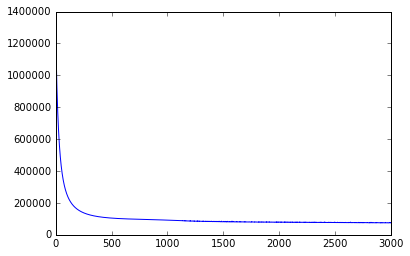

In [21]:
plt.plot(L)

In [11]:
# end of rec data